In [ ]:
!pip install minterpy

In [ ]:
import minterpy as mp
import numpy as np
import time
from matplotlib import pyplot as plt
import sympy as sp
from tabulate import tabulate


def M(x):
    """
    Example of input values:
        x = [[1,2,3,4,5,6,7,8],
            [1,2,3,4,5,6,7,8],
            [1,2,3,4,5,6,7,8],
            ....
            [1,2,3,4,5,6,7,8]]

    """
    r_w = x[:, 0]
    r = x[:, 1]
    T_u = x[:, 2]
    H_u = x[:, 3]
    T_l = x[:, 4]
    H_l = x[:, 5]
    L = x[:, 6]
    K_w = x[:, 7]

    return 2 * np.pi * T_u * (H_u - H_l) / (np.log(r / r_w) * (1 + T_u / T_l) + 2 * L *T_u / ((r_w**2)*K_w))

bounds = [
       [0.15, 0.05], # r_w
       [50_000, 100], # r
       [115_600, 63_070], # T_u
       [1_100, 990], # H_u
       [116, 63.1], # T_l
       [820, 700], # H_l
       [1_680, 1120], # L
       [12_045, 9_985], # K_w
    ]
abounds = np.array(bounds)
sigma = 0.5 * (abounds[:,1] - abounds[:,0]) # Globally defined bounds needed for translating the domain
mu = 0.5 * (abounds[:,1] + abounds[:,0])

def MU(x):
    """
        Here we perform the scaling from [-1,1] to the original bounds
        of the input variables.

    """
    # Normalize the input
    x = x * sigma + mu

    return M(x)

def MU_universal(x, fun): # Generalized version of MU which evaluates any function after scaling (useful for derivatives)
    # Normalize the input
    x = x * sigma + mu

    return fun(x)


def interpolate(m, n, p, fun):
    """
        Interpolates the function fun using the Chebyshev nodes.
        Returns a polynomial in Newton form.
    """

    mis = mp.MultiIndexSet.from_degree(m, n, p)
    grid = mp.Grid(mis)
    nodes = grid.unisolvent_nodes

    Lagrange_poly = mp.LagrangePolynomial.from_grid(grid, fun(nodes))

    return mp.LagrangeToNewton(Lagrange_poly)()


def RMSE(m, poly, fun, N=1000):
    # Generate N random points from m-dimensional cube [-1,1]^m
    x = np.random.uniform(-1, 1, (N, m))

    # Evaluate polynomial and function at these points
    poly_vals = poly(x)
    fun_vals = fun(x)

    # Compute root mean square error
    rmse = np.sqrt(np.mean((poly_vals - fun_vals)**2))
    rmse_rel = rmse / np.std(fun_vals)
    return rmse, rmse_rel

"""
Below we define the symbols used by SymPy.
We need to do it globally, as many functions will later reference these symbols.
We also define the function M and all its first partial derivatives symbolically.
"""

r_w, r, T_u, H_u, T_l, H_l, L, K_w = sp.symbols('r_w r T_u H_u T_l H_l L K_w')
symbols = [r_w, r, T_u, H_u, T_l, H_l, L, K_w]
symbol_names = ['r_w', 'r', 'T_u', 'H_u', 'T_l', 'H_l', 'L', 'K_w']
symbol_dict = dict(zip(symbol_names, symbols))

log_part = sp.ln(r / r_w)
numerator = 2 * sp.pi * T_u * (H_u - H_l)
denominator = log_part * (1 + (2 * L * T_u) / (log_part * r_w**2 * K_w) + T_u / T_l)
M_final = numerator / denominator # Defining M in terms of SymPy, in order to calculate its derivatives

partial_derivatives = {name: sp.diff(M_final, sym) for name, sym in symbol_dict.items()} # Symbolic notation of all the partial derivatives of M

In [ ]:
def calculate_dgsm(dim, poly): # Calculates DGSM using polynomial multiplication
    deriv = poly.partial_diff(dim, 1) / sigma[dim]
    integrant = (deriv * deriv) / 256.0
    return integrant.integrate_over()

In [ ]:
def plot_active_subspace(eigenvector): # Produces a plot of relation between the active variable and the entire function
    test_variables = np.random.uniform(-1, 1, (1000, 8)) # Generating 1000 random points in [-1, 1]^8
    results = MU(test_variables)
    projection = test_variables @ eigenvector
    plt.figure(figsize=(8, 5))
    plt.scatter(projection, results, s=20, alpha=0.7, edgecolor='k') # Plotting the dependency between projection onto the active variable and value of the function
    plt.xlabel("Active Variable (Projection onto eigenvector with largest eigenvalue)")
    plt.ylabel("Function Output M(x)")
    plt.title("Active Subspace Plot (1D)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def active_subspace(poly): # Active subspace analysis of a polynomial, calculated using polynomial multiplication
    poly_array = [poly.partial_diff(v, 1) for v in range(8)]
    poly_matrix = np.empty((8, 8))
    for i in range(8): # Calculating the entries of matrix C: integration over multiplication of each pair of partial derivatives
        for j in range(8):
            if i > j:
                poly_matrix[i][j] = poly_matrix[j][i] # Matrix C is symmetric
                continue
            poly_temp = (poly_array[i] * poly_array[j]) / 256.0
            poly_matrix[i][j] = poly_temp.integrate_over()
    eigenvalues, eigenvectors = np.linalg.eigh(poly_matrix) # Finding the largest eigenvalue along with its associated eigenvector
    print(eigenvalues)
    v = np.argmax(eigenvalues)
    plot_active_subspace(eigenvectors[:, v])
    activity_scores = eigenvalues[v] * eigenvectors[:, v]**2 # How much each variable contributes to the active subspace
    return activity_scores # Returns activity scores for the active subspace for all variables

In [ ]:
def mult_part_derivatives(dim1: str, dim2: str, m, n, p): # Multiplies two derivatives symbolically, then produces an interpolation of that product
    deriv1 = partial_derivatives[dim1]
    deriv2 = partial_derivatives[dim2]
    mult_result = deriv1 * deriv2 # SymPy calculation of multiplication of derivatives
    mult_result = sp.simplify(mult_result)
    fun = sp.lambdify(symbols, mult_result, 'numpy') # Turning the derivative into actual function

    def vect_fun(x): # Adapting the function input from a vector of 8 values into 8 variables for the lambdified function
        return np.array([fun(*row) for row in x])

    return interpolate(m, n, p, lambda x: MU_universal(x = x, fun = vect_fun))

In [ ]:
def calculate_dgsm_alt(dim, m, n, p): # Calculating DGSM (expected values of squares of derivatives) using SymPy
    dim_name = symbol_names[dim]
    integrant = mult_part_derivatives(dim_name, dim_name, m, n, p)
    integrant = integrant / 256
    return integrant.integrate_over()

In [ ]:
def active_subspace_alt(m, n, p): # Active subspace analysis of a polynomial
    poly_matrix = np.empty((8, 8))
    for i in range(8):
        for j in range(8):
            if i > j:
                poly_matrix[i][j] = poly_matrix[j][i]
                continue
            poly_temp = mult_part_derivatives(symbol_names[i], symbol_names[j], m, n, p) / 256.0
            poly_temp = poly_temp * sigma[i] * sigma[j]
            poly_matrix[i][j] = poly_temp.integrate_over()
    eigenvalues, eigenvectors = np.linalg.eigh(poly_matrix)
    print(eigenvalues)
    v = np.argmax(eigenvalues)
    plot_active_subspace(eigenvectors[:, v])
    activity_scores = eigenvalues[v] * eigenvectors[:, v]**2
    return activity_scores # Returns activity scores for the active subspace for all variables

In [ ]:
def var_mc(m, fun, N=1000): # Borrowed function to estimate the variance
    """
        Compute the variance of the function using Monte Carlo method.
    """
    # Generate N random points from m-dimensional cube [-1,1]^m
    x = np.random.uniform(-1, 1, (N, m))

    # Evaluate function at these points
    fun_vals = fun(x)
    # Compute variance
    var = np.var(fun_vals)

    return var

In [ ]:
def print_ranked_table(variable_names, scores):
    # Pair variable names with scores
    pairs = list(zip(variable_names, scores))

    # Sort by score descending
    sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)

    # Add rank numbers
    ranked_data = [(i+1, var, f"{score:.5f}") for i, (var, score) in enumerate(sorted_pairs)]

    # Print using tabulate
    headers = ["Rank", "Variable", "Score"]
    print(tabulate(ranked_data, headers=headers, tablefmt="github"))

In [ ]:
def main():
    m = 8
    n = 4 # Reduced temporarily due to many expensive polynomial multiplications
    p = 1

    # Time the interpolation
    start_time = time.time()
    poly = interpolate(m, n, p, MU)
    interpolate_time = time.time() - start_time
    print(f"Time spent in interpolate: {interpolate_time:.4f} seconds")

    # Time the RMSE calculation
    start_time = time.time()
    rmse, rmse_rel = RMSE(m, poly, MU)
    rmse_time = time.time() - start_time
    print(f"Time spent in RMSE: {rmse_time:.4f} seconds")
    print(f"RMSE: {rmse}, RMSE_rel = {rmse_rel}")

    dgsm_raw = []
    for v in range(8):
        dgsm_raw.append(calculate_dgsm(v, poly))

    var = var_mc(8, MU)
    dgsm = [((2*sigma[v])**2)/(np.pi**2 * var)*dgsm_raw[v] for v in range(8)]

    n = 6

    dgsm_alt_raw = []
    for v in range(8):
        dgsm_alt_raw.append(calculate_dgsm_alt(v, m, n, p))

    dgsm_alt = [((2*sigma[v])**2)/(np.pi**2 * var)*dgsm_alt_raw[v] for v in range(8)]
    # Interestingly, the value for r increases by a magnitude of 2, while the rest is similar

    active_subspace_result = active_subspace(poly)

    active_subspace_alt_result = active_subspace_alt(m, n, p)

    print_ranked_table(symbol_names, dgsm)
    print("")
    print_ranked_table(symbol_names, dgsm_alt)
    print("")
    print_ranked_table(symbol_names, active_subspace_result)
    print("")
    print_ranked_table(symbol_names, active_subspace_alt_result)

Time spent in interpolate: 0.0749 seconds
Time spent in RMSE: 0.0298 seconds
RMSE: 0.2214357677280605, RMSE_rel = 0.004965907185305188
[5.13557226e-13 1.27850572e-08 1.34668105e-02 1.34062751e-01
 6.77707023e-01 8.46280904e+00 5.27994491e+01 6.56170788e+03]


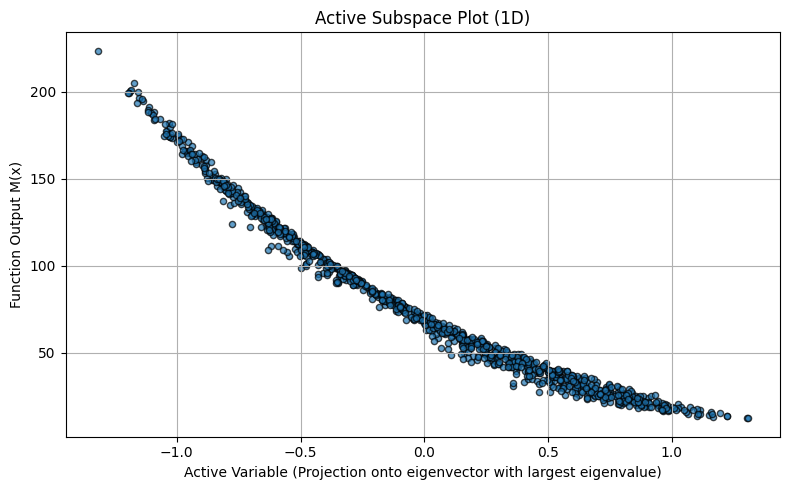

[-8.52066484e+01 -2.73853777e-08  3.01417447e-13  1.55977880e-02
  7.12985319e-01  1.97313346e+01  1.46357547e+02  6.57331946e+03]


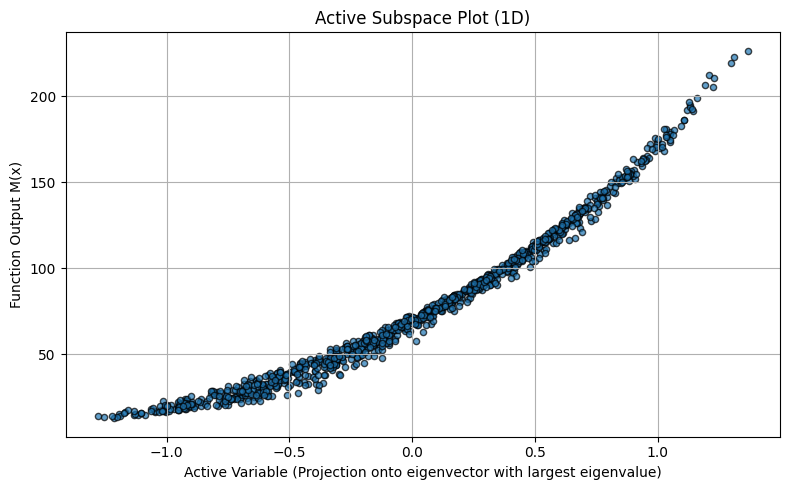

|   Rank | Variable   |   Score |
|--------|------------|---------|
|      1 | r_w        | 1.067   |
|      2 | L          | 0.06486 |
|      3 | H_l        | 0.0642  |
|      4 | H_u        | 0.05394 |
|      5 | K_w        | 0.01278 |
|      6 | r          | 3e-05   |
|      7 | T_l        | 2e-05   |
|      8 | T_u        | 0       |

|   Rank | Variable   |   Score |
|--------|------------|---------|
|      1 | r_w        | 1.06655 |
|      2 | H_l        | 0.06519 |
|      3 | L          | 0.06481 |
|      4 | H_u        | 0.05478 |
|      5 | K_w        | 0.01292 |
|      6 | r          | 0.00451 |
|      7 | T_l        | 2e-05   |
|      8 | T_u        | 0       |

|   Rank | Variable   |      Score |
|--------|------------|------------|
|      1 | r_w        | 5588.91    |
|      2 | L          |  324.093   |
|      3 | H_l        |  317.443   |
|      4 | H_u        |  266.74    |
|      5 | K_w        |   64.4201  |
|      6 | T_l        |    0.07448 |
|      7 | r          

In [ ]:
if __name__ == "__main__":
    main()